# Deep Learning Time Series COVID-19 Cases Prediction

## Project Setup

### Dependencies importing

In [14]:
# Auto reload imported module every time a jupyter cell is executed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import pandas as pd
import scipy
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import requests
import pandas_profiling
from typing import overload
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop 
from covid_time_series_prediction.ml_logic import preprocessor
from covid_time_series_prediction.dp_logic.sequencing import subsample_sequence, get_X_y, get_X_y_2
from covid_time_series_prediction.dp_logic.RNN_model import model_run
from covid_time_series_prediction.ml_logic.preprocessor import train_test_set
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Data loading

In [ ]:
data_dir = '../data/raw_data/'

df_raw_gov_response = pd.read_csv(data_dir + 'government_response_index_avg.csv')
df_raw_health = pd.read_csv(data_dir + 'containment_health_index_avg.csv')
df_raw_economic = pd.read_csv(data_dir + 'economic_support_index.csv')

#### Vaccination
df_raw_vaccination = pd.read_csv(data_dir + 'vaccinations.csv')
df_raw_ages = pd.read_csv(data_dir + 'vaccinations-by-age-group.csv')


#### Data Frame target
df_raw_cases = pd.read_csv(data_dir + 'confirmed_cases.csv')
df_raw_deaths = pd.read_csv(data_dir + 'confirmed_deaths.csv')

#### Data multiple
df_raw_school_closing=pd.read_csv(data_dir + 'c1m_school_closing.csv')
df_raw_workplace_closing=pd.read_csv(data_dir + 'c2m_workplace_closing.csv')
df_raw_cancel_public_event=pd.read_csv(data_dir + 'c3m_cancel_public_events.csv')
df_raw_restriction_on_gathering=pd.read_csv(data_dir + 'c4m_restrictions_on_gatherings.csv')
df_raw_stay_at_home=pd.read_csv(data_dir + 'c6m_stay_at_home_requirements.csv')
df_raw_international_travel=pd.read_csv(data_dir + 'c6m_stay_at_home_requirements.csv')
df_raw_goverment_response=pd.read_csv(data_dir + 'government_response_index_avg.csv')
df_raw_facial_covering=pd.read_csv(data_dir + 'h6m_facial_coverings.csv')
df_raw_vacination_policy=pd.read_csv(data_dir + 'h7_vaccination_policy.csv')


### **Read out CSV** and **Set dataframe**

## DataFrames setting

In [ ]:
#### CSV Data out project directory
csv_dir = '../data/out_csv/'
# ! unzip {csv_dir}usa_index
# ! unzip {csv_dir}usa_indicator
# ! rm ECG_data.zip
df_fr_index =  pd.read_csv(csv_dir + 'index_FRA.csv')
df_fr_indicator =  pd.read_csv(csv_dir + 'indicator_FRA.csv')
df_fr_index, df_fr_indicator


# Sumedha csv test
df_ts_fra_index =  df_fr_index.copy()
df_ts_fra_indicator =  df_fr_indicator.copy()

df_ts_fra_index.head(), df_ts_fra_indicator.head()

In [ ]:
df_ts_fra_indicator = df_ts_fra_indicator.set_index('date')
X_ts_fra_indicator = df_ts_fra_indicator.drop(columns=['total_deaths','new_deaths','new_cases'])
y_ts_fra_indicator = df_ts_fra_indicator['total_deaths']

## TENSORFLOW & RNN MODEL

### Recurrent Neural Network (sequences data) modeling

### Samples/Sequences, Observations, Features

X.shape = (n_SEQUENCES, n_OBSERVATIONS, n_FEATURES) and y = RNN(X) where $X_{i,j}^{t}$

with $_{i}$ is the sample/sequence, $_{j}$ is the feature measured and  $^{t}$ is the time at which the observation is seen



### Prerequisites:

- **retrieve dataset** from Sumedha & Alberto

    - **clean dataset**: 
        
        - **drop first lines == 0** *(before Covid arrived)*
        
        - **check Nan**: 
- **strategy 1 country by country** sequences split as follow:

- **strategy 2 one sequence per country**:
    - **split X train, set** 
    - **Pad sequences**
    - **create one csv per country**

## Training strategies:
- Get NB dataset (cleaned) from Alberto & Sumedha
- 1/ Indicator in precentage %
- 2/ Indicator as categorical labels
- Run same RNN model in parallel with Kim & Thomas
- Identify best dataset
- Parameters to fit:
    - increase **nb of sequences**
    - train series modulation (ex: [50, 150, 200, 300, 400 nb of days = n_obs]) < take time to compute
    - **learning_rate** in Optimizer(parameters)
    - model layers architecture (**simple** -> complex) (less data -> more data) (print(loss) function check lecture)
        > LSTM
        > Dense
       (> LSTM
        > LSTM
        > Dense)
     >> **try to overfit** the model with the loss (train over val) or (early_stopping)
     >> **(X_val, y_val)**

## **RNN** models on **FRA** country with **Alberto**'s datasets

In [16]:
# Alberto train set
n_seq = 200 ## nb of sequences (samples)
n_obs = [70, 65, 60] # maxi = 96 (stay around 70 or more test_split)
n_obs = 70 # maxi = 96 (stay around 70 or more test_split)
n_feat = 20 #  X_train.shape[1] # 20 feature:
n_pred = 10 # nb of days where we can predict new daily deaths
n_pred = 1 ## <<< REMOVE AFTER OK TESTING!
n_seq_val = n_seq // 5 # number of sequences in test set ?
n_seq_test = n_seq // 10 # number of sequences in test set ?
print('n_seq\t\t', n_seq, '\nn_seq_val\t', n_seq_val, '\nn_seq_test\t', n_seq_test, '\nn_obs\t\t', n_obs, '\nn_feat\t\t', n_feat)

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20


### Train Splitting

Split the dataset into training, validation, and test data

In [17]:
# Alberto train set
X_train, y_train, X_val, y_val, X_test, y_test = train_test_set('Vietnam', split_train=0.7, split_val=0.9)
print('X_train.shape\t', X_train.shape, '\t->\ty_train shape\t', y_train.shape, '\nX_val.shape\t', X_val.shape, '\t->\ty_val shape\t', y_val.shape, '\nX_test.shape\t', X_test.shape, '\t->\ty_test shape\t', y_test.shape)

X_train.shape	 (673, 21) 	->	y_train shape	 (673,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)


#### Create sequences (`X`,`y`, `X_len`, `y_len`)

##### Generates an entire dataset of multiple subsamples with shape $(X, y)$

In [18]:
X_test, y_test = get_X_y_2(X_test, y_test, X_len=n_obs, y_len=n_pred, n_sequences=n_seq_test)
print('n_seq_test / n_obs / n_feat', n_seq_test, n_obs, n_feat, '\nX_test.shape', X_test.shape, 'y_test.shape', y_test.shape) 

n_seq_test / n_obs / n_feat 20 70 20 
X_test.shape (20, 70, 21) y_test.shape (20, 1)


In [19]:
X_train, y_train = get_X_y_2(X_train, y_train, X_len=n_obs, y_len=n_pred, n_sequences=n_seq)
print('n_seq / n_obs / n_feat', n_seq, n_obs, n_feat, '\nX_train.shape', X_train.shape, 'y_train.shape', y_train.shape) 

n_seq / n_obs / n_feat 200 70 20 
X_train.shape (200, 70, 21) y_train.shape (200, 1)


In [20]:
X_val, y_val = get_X_y_2(X_val, y_val, X_len=n_obs, y_len=n_pred, n_sequences=n_seq_val)
print('n_seq_val / n_obs / n_feat', n_seq_val, n_obs, n_feat, '\nX_val.shape', X_val.shape, 'y_val.shape', y_val.shape) 

n_seq_val / n_obs / n_feat 40 70 20 
X_val.shape (40, 70, 21) y_val.shape (40, 1)


##### How to split sequences?



- randomly or

- manually

##### **train_rnn_model(model, patience=2, epochs=200):**

function to generates an entire dataset of multiple subsamples suitable for RNN, that is, $(X, y)$ of shape:

```python
X.shape = (n_sequences, length, n_features)
y.shape = (n_sequences, )
```

### Model #4 Training

In [21]:
print('X_train.shape\t', X_train.shape, '\t->\ty_train shape\t', y_train.shape, '\nX_val.shape\t', X_val.shape, '\t->\ty_val shape\t', y_val.shape, '\nX_test.shape\t', X_test.shape, '\t->\ty_test shape\t', y_test.shape)
print('type(X_train)\t', type(X_train), '\t->\ttype(y_train)\t', type(y_train), '\ntype(X_val)\t', type(X_val), '\t->\ttype(y_val)\t', type(y_val), '\ntype(X_test)\t', type(X_test), '\t->\ttype(y_test)\t', type(y_test))


X_train.shape	 (200, 70, 21) 	->	y_train shape	 (200, 1) 
X_val.shape	 (40, 70, 21) 	->	y_val shape	 (40, 1) 
X_test.shape	 (20, 70, 21) 	->	y_test shape	 (20, 1)
type(X_train)	 <class 'numpy.ndarray'> 	->	type(y_train)	 <class 'numpy.ndarray'> 
type(X_val)	 <class 'numpy.ndarray'> 	->	type(y_val)	 <class 'numpy.ndarray'> 
type(X_test)	 <class 'numpy.ndarray'> 	->	type(y_test)	 <class 'numpy.ndarray'>


MAPE [96.56584930419922, 29.80632972717285, 27.72663116455078, 24.679311752319336, 23.82086944580078, 29.009653091430664, 19.50115394592285, 21.560869216918945, 22.879077911376953, 20.688974380493164, 25.163223266601562, 19.530517578125, 16.566621780395508, 18.667938232421875]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 55 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 55, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 55, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 55, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_147 (LSTM)             (None, 55, 20)            3360      
                                                                 
 lstm_148 (LSTM)     

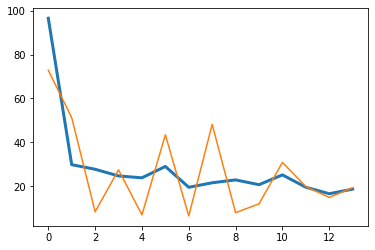

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [98.77178955078125, 205.59324645996094, 99.99466705322266, 99.99353790283203, 99.99215698242188, 99.99043273925781, 99.98860168457031, 99.98678588867188]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 55 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 55, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 55, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 55, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_149 (LSTM)             (None, 55, 20)            3360      
                                                                 
 lstm_150 (LSTM)             (None, 10)                1240      
       

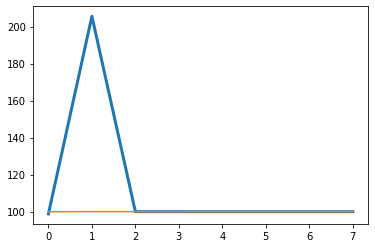

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [99.90562438964844, 435.5503234863281, 1298.4656982421875, 641.6520385742188, 108.30314636230469, 1940.460205078125, 2274.766357421875, 1900.3675537109375, 1507.4224853515625, 176.6142578125, 98.40019226074219, 98.40008544921875]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_153 (LSTM)             (None, 60, 20)            3360      
                      

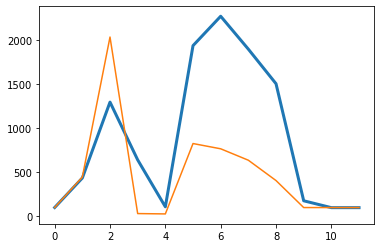

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [408.752197265625, 64.254150390625, 65.41039276123047, 69.70283508300781, 79.20379638671875, 101.65460968017578, 58.89271545410156, 17.983230590820312, 32.148258209228516, 41.295928955078125, 45.9381217956543, 64.01237487792969, nan, nan, nan]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_155 (LSTM)             (None, 60, 20)            3360      
                                                 

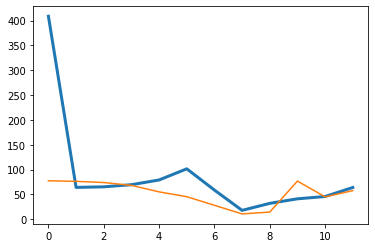

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [99.99717712402344, 99.99101257324219, 99.98880767822266, 99.98483276367188, 99.98149108886719, 99.97676849365234, 99.9809799194336, 99.97453308105469, 99.9679946899414, 99.9617691040039, 99.95114135742188, 99.95429992675781, 99.954345703125, 99.94863891601562, 99.94755554199219, 99.9450454711914, 99.93536376953125, 99.9426040649414, 99.95647430419922, 99.95043182373047, 99.9334487915039, 99.9397201538086, 99.91165924072266, 99.91831970214844, 99.79498291015625, 99.5973129272461, 99.40986633300781, 99.40312194824219, 99.28787231445312, 99.62779998779297, 99.59400177001953, 99.6387710571289, 99.66478729248047, 99.70117950439453, 99.63717651367188]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_tra

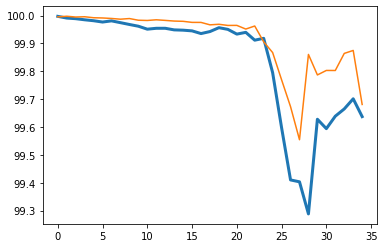

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [89.97286987304688, 101.1747817993164, 99.8786849975586, 99.84420013427734, 99.82176971435547, 99.82987213134766, 99.81692504882812, 99.8171157836914]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 65, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 65, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 65, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_161 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_162 (LSTM)             (None, 10)                1240      
          

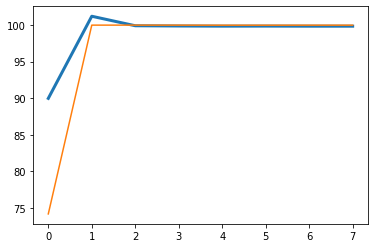

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [99.99984741210938, 99.59487915039062, 89.17870330810547, 85.8886947631836, 84.59794616699219, 97.25279998779297, 97.50468444824219, 97.3379135131836, 97.04053497314453]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 70, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 70, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 70, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_165 (LSTM)             (None, 70, 20)            3360      
                                                                 
 lstm_166 (LSTM)

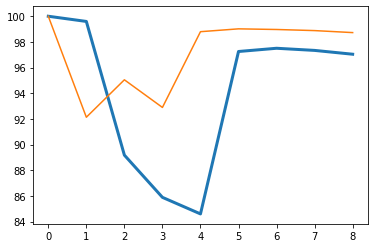

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [99.9988021850586, 99.99253845214844, 99.95187377929688, nan, nan, nan, nan, nan, nan]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 70, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 70, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 70, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_167 (LSTM)             (None, 70, 20)            3360      
                                                                 
 lstm_168 (LSTM)             (None, 10)                1240      
                                                                 
 dense_1

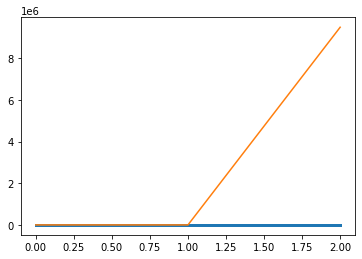

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [99.97522735595703, 97.16790008544922, 87.51921844482422, 78.84963989257812, 79.8018798828125, 81.8302230834961, 98.7911148071289, 94.02639770507812, 62.6619987487793, 72.94798278808594, 88.718994140625, 105.73719024658203, 96.20909118652344, 85.91722869873047, 85.67103576660156, 79.73723602294922, 77.42896270751953, 72.52311706542969, 72.26765441894531, 60.1829719543457, 58.5067024230957, 53.128684997558594, 61.81407165527344, 62.18263626098633, 67.40951538085938, 61.992488861083984, 175.9393768310547]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 55 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 55, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 55, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 55

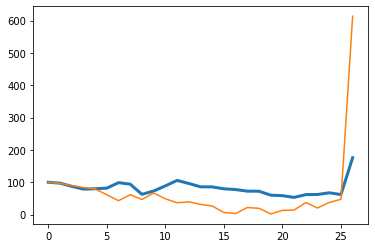

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [3046.31689453125, 99.99881744384766, 99.99850463867188, 99.99777221679688, 99.99674987792969, 99.99543762207031, 99.99337005615234, 99.99156188964844, 99.98841094970703, 99.98572540283203, 99.9822006225586, 99.9793930053711, 99.97582244873047, 99.97240447998047, 99.9681167602539, 99.96395874023438, 99.96068572998047, 99.95594787597656, 99.95101928710938, 99.94688415527344, 99.9421615600586, 99.93700408935547, 99.93132019042969, 99.92665100097656, 99.92109680175781, 99.91517639160156, 99.9080581665039, 99.90185546875, 99.89275360107422, 99.88219451904297, 99.86876678466797, 99.85623931884766, 99.84248352050781, 99.82677459716797, 99.80921173095703, 99.79450988769531, 99.77721405029297, 99.75497436523438, 99.73713684082031, 99.71769714355469, 99.69808959960938, 99.67794799804688, 99.65383911132812, 99.63241577148438, 99.60742950439453, 99.5881576538086, 99.55816650390625, 99.53718566894531, 99.51415252685547, 99.482

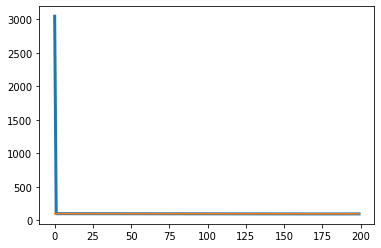

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [99.98682403564453, 99.13729858398438, 105.07475280761719, 98.29332733154297, 96.79118347167969, 86.48473358154297, 144.90170288085938, 80.47337341308594, 84.56494140625]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_180 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_181 (LSTM

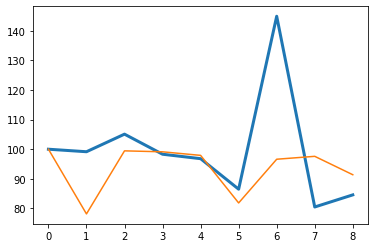

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [206.77537536621094, 99.99703216552734, 99.91029357910156, 99.93604278564453, 99.98253631591797, 102206.8671875, 2100.185546875, 96.86730194091797, 96.86425018310547, 96.85790252685547, 96.84611511230469, 96.82778930664062, 96.79476928710938, 96.75122833251953, 96.67398071289062, 96.55778503417969, 96.4040756225586, 2000.84228515625, 1557.0128173828125, 925.5956420898438, 827.703369140625, 820.9034423828125, 423.1763000488281, 285.9817810058594, 224.89378356933594, 213.80979919433594]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_76"
_

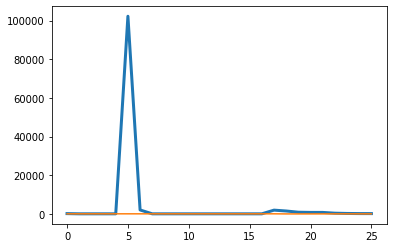

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [126.29936218261719, 143.61990356445312, 98.59835815429688, 99.41797637939453, 93.61273193359375, 79.78316497802734, 79.46569061279297, 83.67082977294922, 81.9178695678711, 78.48818969726562, 81.93651580810547, 86.21635437011719, 77.29421997070312, 74.5155029296875, 83.64784240722656]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 65, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 65, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 65, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_189 (LSTM)             (No

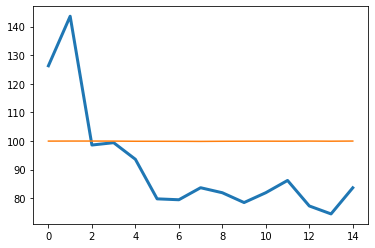

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [100.0, 99.99417877197266, 97.2687759399414, 90.94426727294922, 87.75505065917969, 86.3396987915039, 84.40589904785156, 83.07974243164062, 78.18792724609375, 72.23246765136719, 70.61958312988281, 68.6841812133789, 65.98873901367188, 66.51541900634766, 69.3125991821289, 67.03671264648438, 69.23255157470703, 73.28557586669922, 75.73028564453125, 78.1576919555664, 76.74482727050781]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 70, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 70, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 70, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_81"
__________________________

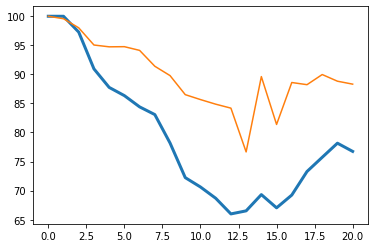

BEST MAPE: 16.566621780395508
with model #1, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [85.26535034179688, 57.54792785644531, 56.587886810302734, 54.173648834228516, 57.989463806152344, 54.13157653808594, 56.313167572021484, 60.05509948730469, 62.567752838134766, 60.74722671508789, 55.335968017578125, 58.529693603515625, 49.444454193115234, 35.06071472167969, 28.81472396850586, 26.298032760620117, 25.255088806152344, 26.491249084472656, 20.061620712280273, 22.0880184173584, 20.609682083129883, 18.931428909301758, 21.643882751464844, 19.45661735534668, 19.68599510192871, 20.225563049316406, 18.82080841064453, 19.66228675842285, 18.008085250854492, 15.36600112915039, 21.11447525024414, 16.578763961791992, 16.834896087646484, 22.73016929626465, 18.581605911254883, 16.234630584716797, 15.513265609741211, 18.420669555664062, 17.16140365600586, 20.21446990966797, 16.971437454223633, 19.189151763916016, 11.90131950378418, 17.5

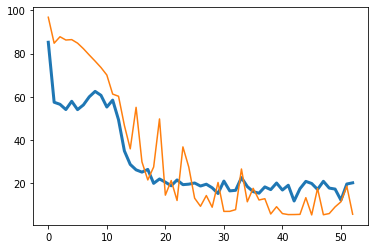

BEST MAPE: 11.90131950378418
with model #3, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [239.0439910888672, 686.8764038085938, 276.33392333984375, 674.2726440429688, 1261.083740234375, 3116.18310546875, 1815.7691650390625, 702.5134887695312, 351.8888244628906]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_216 (LSTM)             (None, 60, 20)            3360      
                                       

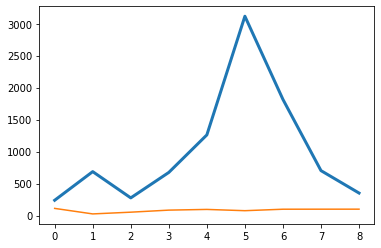

BEST MAPE: 11.90131950378418
with model #3, nb obs: 55, lr: 0.001
MAPE [11076.5625, 99.99981689453125, 99.99978637695312, 99.999755859375, 99.99971008300781, 99.99964904785156, 99.99951934814453, 99.99930572509766, 99.99896240234375, 99.99842071533203, 99.99775695800781, 99.9970474243164, 99.99633026123047, 99.991943359375, 317.0343017578125, 99.9951171875, nan, nan, nan, nan, nan, nan, nan]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_219 (LSTM)             (None, 

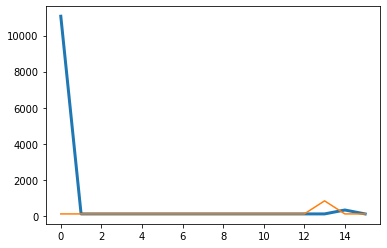

BEST MAPE: 11.90131950378418
with model #3, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [99.8135757446289, 88.32743835449219, 85.02877044677734, 53.047607421875, 49.937068939208984, 43.499839782714844, 27.39411163330078, 21.927734375, 22.862016677856445, 21.232118606567383, 14.4612455368042, 19.167566299438477, 19.574573516845703, 23.620954513549805, 86.01109313964844, 64.34375, 242.2554168701172, 276.4283447265625]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 65, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 65, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 65, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape            

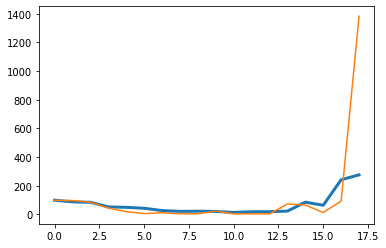

BEST MAPE: 11.90131950378418
with model #3, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [nan, nan, nan, nan, nan, nan, nan]
MAPE [94.83489227294922, 55.9688835144043, 38.00909423828125, 25.577608108520508, 27.103626251220703, 29.489397048950195, 25.44866371154785, 28.21465492248535, 18.650815963745117, 27.196748733520508, 19.663742065429688, 25.99732208251953, 24.915441513061523]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 70, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 70, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 70, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_234 (LSTM)        

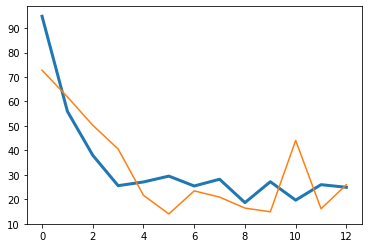

BEST MAPE: 11.90131950378418
with model #3, nb obs: 55, lr: 0.001
MAPE [99.99980163574219, 99.99946594238281, 97.8946762084961, nan, nan, nan, nan, nan, nan, nan]
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 1
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 70, 21) 	->	y_train_seq shape	 (200, 1) 
X_val_seq.shape	 (40, 70, 21) 	->	y_val_seq shape	 (40, 1) 
X_test_seq.shape	 (20, 70, 21) 	->	y_test_seq shape	 (20, 1)
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_237 (LSTM)             (None, 70, 20)            3360      
                                                                 
 lstm_238 (LSTM)             (None, 70, 30)            6120      
                                                                 
 lst

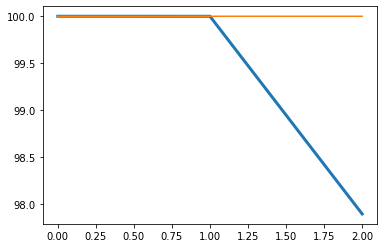

BEST MAPE: 11.90131950378418
with model #3, nb obs: 55, lr: 0.001
MAPE [nan, nan, nan, nan, nan, nan, nan]


In [27]:
### LET TEST IT NOW!

model_run(country_name=
          'France', n_seq=200, n_obs=[55, 60, 65, 70], n_feat=20, n_pred=1, split_train=0.7, split_val=0.9, learning_rates=[0.001, 0.01, 0.1])

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 55 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 55, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 55, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 55, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_267 (LSTM)             (None, 55, 20)            3360      
                                                                 
 lstm_268 (LSTM)             (None, 10)                1240      
                                                                 
 dense_210 (Dense)           (None, 10)                110       
                                                                 
 dense_211 (Dense)           (None

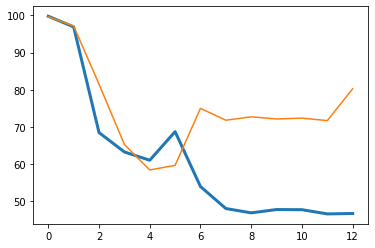

BEST MAPE: 46.596675872802734
with model #1, nb obs: 55, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 55 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 55, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 55, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 55, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_271 (LSTM)             (None, 55, 20)            3360      
                                                                 
 lstm_272 (LSTM)             (None, 10)                1240      
                                                                 
 dense_214 (Dense)           (None, 10)                110       
                                 

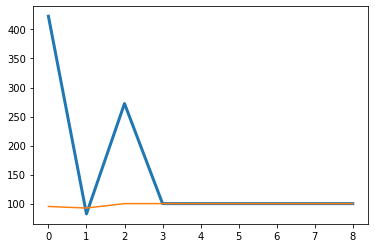

BEST MAPE: 46.596675872802734
with model #1, nb obs: 55, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_273 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_274 (LSTM)             (None, 10)                1240      
                                                                 
 dense_216 (Dense)           (None, 10)                110       
                                 

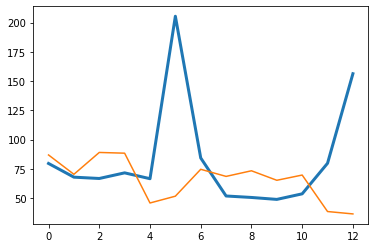

BEST MAPE: 46.596675872802734
with model #1, nb obs: 55, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_275 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_276 (LSTM)             (None, 10)                1240      
                                                                 
 dense_218 (Dense)           (None, 10)                110       
                                 

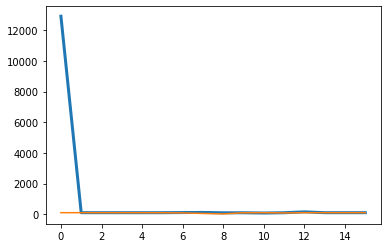

BEST MAPE: 46.596675872802734
with model #1, nb obs: 55, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_277 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_278 (LSTM)             (None, 10)                1240      
                                                                 
 dense_220 (Dense)           (None, 10)                110       
                                 

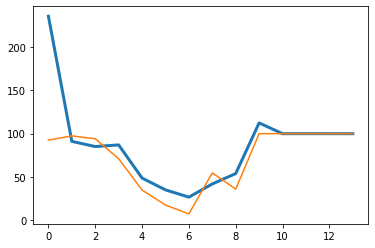

BEST MAPE: 26.892534255981445
with model #1, nb obs: 60, lr: 0.01
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 65, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 65, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 65, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_279 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_280 (LSTM)             (None, 10)                1240      
                                                                 
 dense_222 (Dense)           (None, 10)                110       
                                  

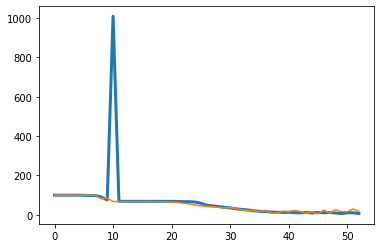

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 65, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 65, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 65, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_283 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_284 (LSTM)             (None, 10)                1240      
                                                                 
 dense_226 (Dense)           (None, 10)                110       
                                  

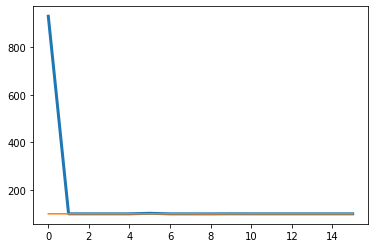

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 55 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 55, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 55, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 55, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_285 (LSTM)             (None, 55, 20)            3360      
                                                                 
 lstm_286 (LSTM)             (None, 55, 20)            3280      
                                                                 
 lstm_287 (LSTM)             (None, 10)                1240      
                                  

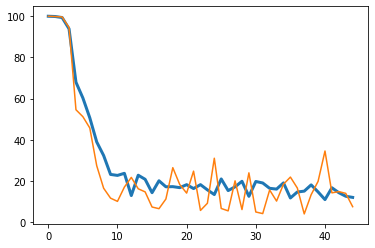

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 55 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 55, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 55, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 55, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_291 (LSTM)             (None, 55, 20)            3360      
                                                                 
 lstm_292 (LSTM)             (None, 55, 20)            3280      
                                                                 
 lstm_293 (LSTM)             (None, 10)                1240      
                                  

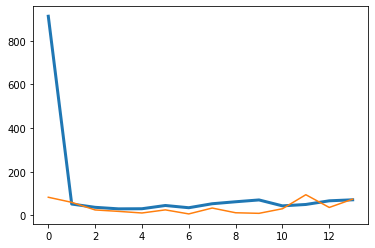

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_294 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_295 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_296 (LSTM)             (None, 10)                1240      
                                  

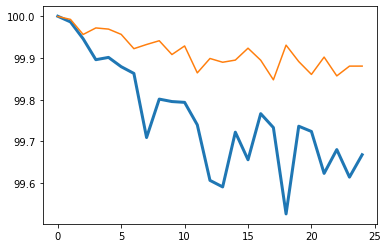

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_300 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_301 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_302 (LSTM)             (None, 10)                1240      
                                  

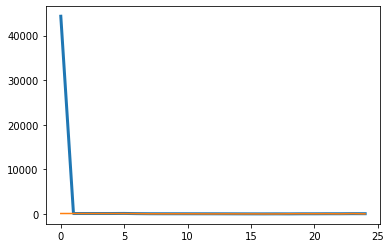

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 65, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 65, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 65, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_303 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_304 (LSTM)             (None, 65, 20)            3280      
                                                                 
 lstm_305 (LSTM)             (None, 10)                1240      
                                  

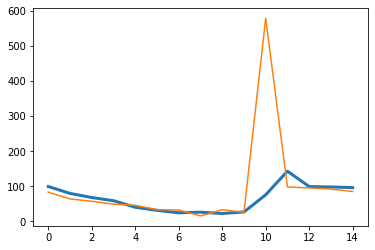

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 65, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 65, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 65, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_309 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_310 (LSTM)             (None, 65, 20)            3280      
                                                                 
 lstm_311 (LSTM)             (None, 10)                1240      
                                  

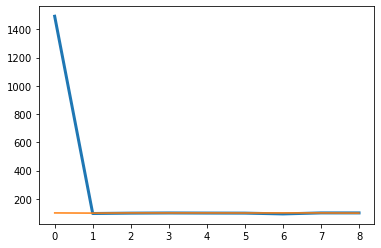

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 55 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 55, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 55, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 55, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_312 (LSTM)             (None, 55, 20)            3360      
                                                                 
 dropout_3 (Dropout)         (None, 55, 20)            0         
                                                                 
 lstm_313 (LSTM)             (None, 55, 30)            6120      
                                  

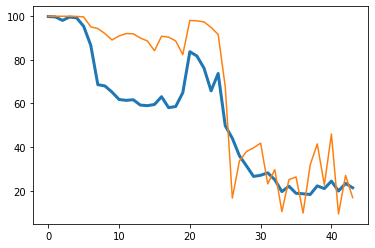

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 55 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 55, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 55, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 55, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_318 (LSTM)             (None, 55, 20)            3360      
                                                                 
 dropout_5 (Dropout)         (None, 55, 20)            0         
                                                                 
 lstm_319 (LSTM)             (None, 55, 30)            6120      
                                  

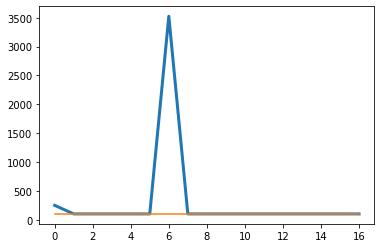

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_321 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_6 (Dropout)         (None, 60, 20)            0         
                                                                 
 lstm_322 (LSTM)             (None, 60, 30)            6120      
                                  

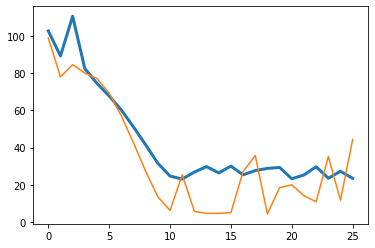

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 60, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 60, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 60, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_327 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_8 (Dropout)         (None, 60, 20)            0         
                                                                 
 lstm_328 (LSTM)             (None, 60, 30)            6120      
                                  

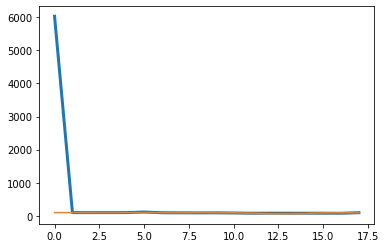

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 65, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 65, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 65, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_330 (LSTM)             (None, 65, 20)            3360      
                                                                 
 dropout_9 (Dropout)         (None, 65, 20)            0         
                                                                 
 lstm_331 (LSTM)             (None, 65, 30)            6120      
                                  

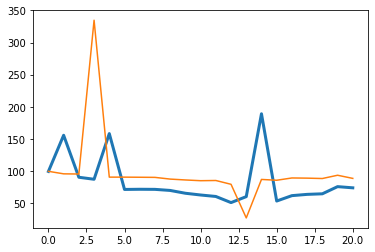

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 3
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape	 (200, 65, 21) 	->	y_train_seq shape	 (200, 3) 
X_val_seq.shape	 (40, 65, 21) 	->	y_val_seq shape	 (40, 3) 
X_test_seq.shape	 (20, 65, 21) 	->	y_test_seq shape	 (20, 3)
Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_336 (LSTM)             (None, 65, 20)            3360      
                                                                 
 dropout_11 (Dropout)        (None, 65, 20)            0         
                                                                 
 lstm_337 (LSTM)             (None, 65, 30)            6120      
                                  

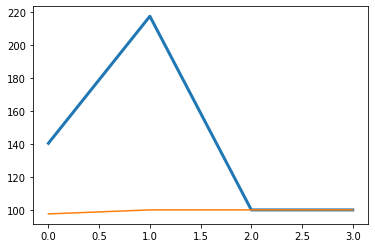

BEST MAPE: 6.837233066558838
with model #1, nb obs: 65, lr: 0.001


In [29]:
model_run(country_name='France', n_seq=200, n_obs=[55, 60, 65], n_feat=20, n_pred=3, split_train=0.7, split_val=0.9, learning_rates=[0.001, 0.05,0.01])

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 65, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 65, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 65, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_339 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_340 (LSTM)             (None, 10)                1240      
                                                                 
 dense_264 (Dense)           (None, 10)                110       
                                                                 
 dense_265 (Dense)           (None, 7

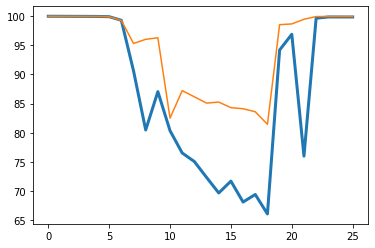

BEST MAPE: 66.04940795898438
with model #1, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 65, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 65, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 65, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_341 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_342 (LSTM)             (None, 10)                1240      
                                                                 
 dense_266 (Dense)           (None, 10)                110       
                                     

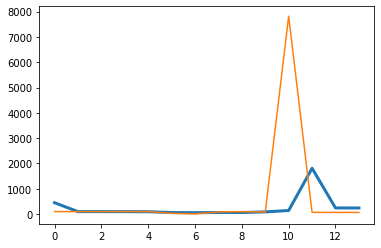

BEST MAPE: 56.245147705078125
with model #1, nb obs: 65, lr: 0.01
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 70, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 70, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 70, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_343 (LSTM)             (None, 70, 20)            3360      
                                                                 
 lstm_344 (LSTM)             (None, 10)                1240      
                                                                 
 dense_268 (Dense)           (None, 10)                110       
                                     

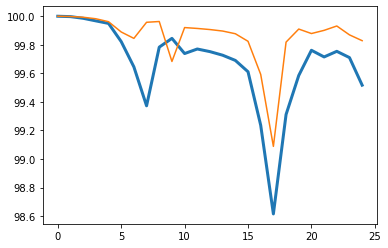

BEST MAPE: 56.245147705078125
with model #1, nb obs: 65, lr: 0.01
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 70, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 70, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 70, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_345 (LSTM)             (None, 70, 20)            3360      
                                                                 
 lstm_346 (LSTM)             (None, 10)                1240      
                                                                 
 dense_270 (Dense)           (None, 10)                110       
                                     

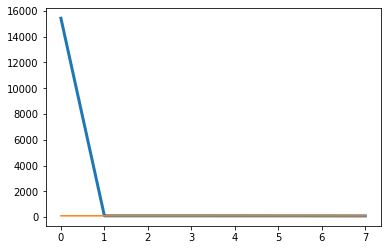

BEST MAPE: 56.245147705078125
with model #1, nb obs: 65, lr: 0.01
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 65, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 65, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 65, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_347 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_348 (LSTM)             (None, 65, 20)            3280      
                                                                 
 lstm_349 (LSTM)             (None, 10)                1240      
                                     

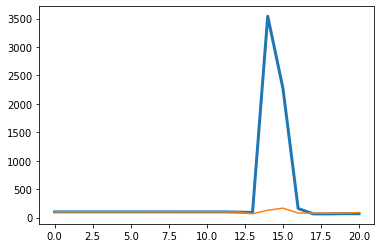

BEST MAPE: 56.245147705078125
with model #1, nb obs: 65, lr: 0.01
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 70, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 70, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 70, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_353 (LSTM)             (None, 70, 20)            3360      
                                                                 
 lstm_354 (LSTM)             (None, 70, 20)            3280      
                                                                 
 lstm_355 (LSTM)             (None, 10)                1240      
                                     

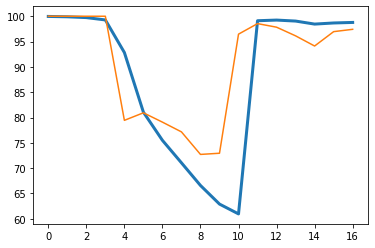

BEST MAPE: 56.245147705078125
with model #1, nb obs: 65, lr: 0.01
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 70, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 70, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 70, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_356 (LSTM)             (None, 70, 20)            3360      
                                                                 
 lstm_357 (LSTM)             (None, 70, 20)            3280      
                                                                 
 lstm_358 (LSTM)             (None, 10)                1240      
                                     

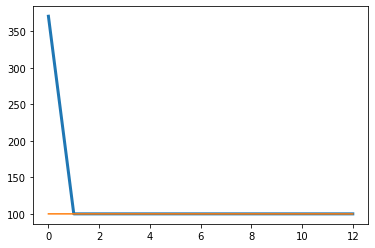

BEST MAPE: 56.245147705078125
with model #1, nb obs: 65, lr: 0.01
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 65, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 65, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 65, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_359 (LSTM)             (None, 65, 20)            3360      
                                                                 
 dropout_12 (Dropout)        (None, 65, 20)            0         
                                                                 
 lstm_360 (LSTM)             (None, 65, 30)            6120      
                                     

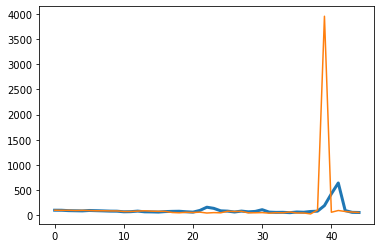

BEST MAPE: 51.26433563232422
with model #3, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 65, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 65, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 65, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_362 (LSTM)             (None, 65, 20)            3360      
                                                                 
 dropout_13 (Dropout)        (None, 65, 20)            0         
                                                                 
 lstm_363 (LSTM)             (None, 65, 30)            6120      
                                     

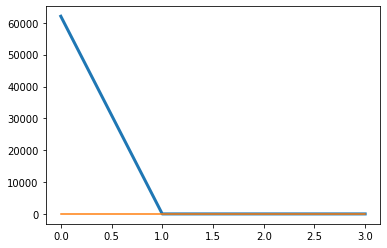

BEST MAPE: 51.26433563232422
with model #3, nb obs: 65, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 70 
n_feat		 20 
n_pred		 7
X_train.shape	 (672, 21) 	->	y_train shape	 (672,) 
X_val.shape	 (192, 21) 	->	y_val shape	 (192,) 
X_test.shape	 (97, 21) 	->	y_test shape	 (97,)
X_train_seq.shape (200, 70, 21) 	->	y_train_seq shape	 (200, 7) 
X_val_seq.shape (40, 70, 21) 	->	y_val_seq shape	 (40, 7) 
X_test_seq.shape (20, 70, 21) 	->	y_test_seq shape	 (20, 7)
Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_365 (LSTM)             (None, 70, 20)            3360      
                                                                 
 dropout_14 (Dropout)        (None, 70, 20)            0         
                                                                 
 lstm_366 (LSTM)             (None, 70, 30)            6120      
                                     

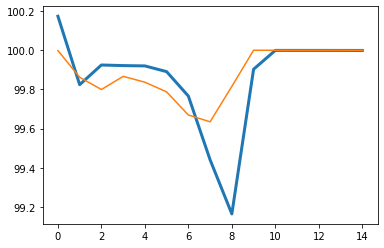

BEST MAPE: 51.26433563232422
with model #3, nb obs: 65, lr: 0.001


In [30]:
model_run(country_name='France', n_seq=200, n_obs=[65, 70], n_feat=20, n_pred=7, split_train=0.7, split_val=0.9, learning_rates=[0.001, 0.01])

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_371 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_372 (LSTM)             (None, 10)                1240      
                                                                 
 dense_288 (Dense)           (None, 10)                110       
                                                                 
 dense_289 (Dense)           (None, 10)                110       
                                       

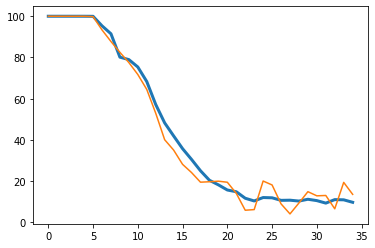

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_373 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_374 (LSTM)             (None, 10)                1240      
                                                                 
 dense_290 (Dense)           (None, 10)                110       
                                                                 
 dense_291 (Dense)           (None, 10)

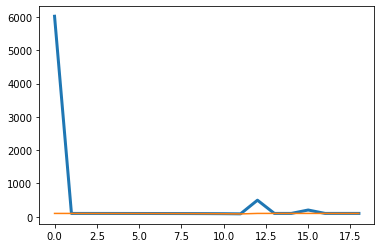

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 65, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 65, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 65, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_375 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_376 (LSTM)             (None, 10)                1240      
                                                                 
 dense_292 (Dense)           (None, 10)                110       
                                                                 
 dense_293 (Dense)           (None, 10)

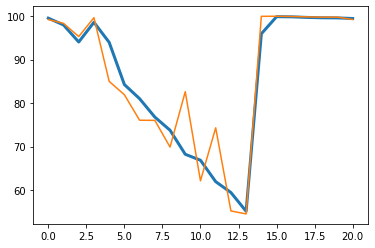

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_379 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_380 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_381 (LSTM)             (None, 10)                1240      
                                                                 
 dense_296 (Dense)           (None, 10)

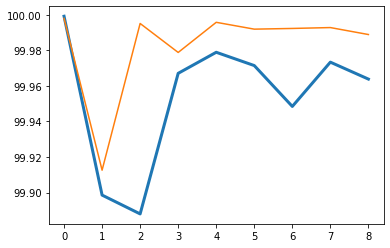

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_382 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_383 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_384 (LSTM)             (None, 10)                1240      
                                                                 
 dense_298 (Dense)           (None, 10)

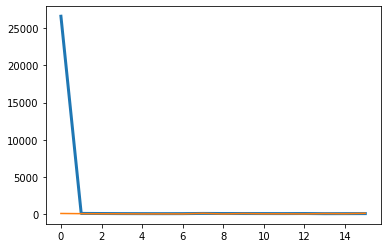

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 65, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 65, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 65, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_385 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_386 (LSTM)             (None, 65, 20)            3280      
                                                                 
 lstm_387 (LSTM)             (None, 10)                1240      
                                                                 
 dense_300 (Dense)           (None, 10)

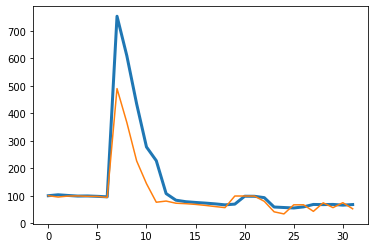

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_391 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_16 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_392 (LSTM)             (None, 60, 30)            6120      
                                                                 
 lstm_393 (LSTM)             (None, 20)

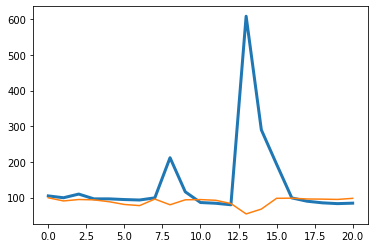

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_394 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_17 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_395 (LSTM)             (None, 60, 30)            6120      
                                                                 
 lstm_396 (LSTM)             (None, 20)

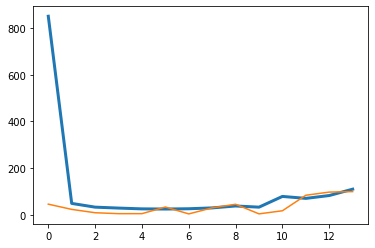

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 65, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 65, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 65, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_397 (LSTM)             (None, 65, 20)            3360      
                                                                 
 dropout_18 (Dropout)        (None, 65, 20)            0         
                                                                 
 lstm_398 (LSTM)             (None, 65, 30)            6120      
                                                                 
 lstm_399 (LSTM)             (None, 20)

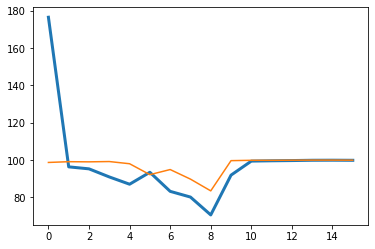

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 65, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 65, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 65, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_155"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_400 (LSTM)             (None, 65, 20)            3360      
                                                                 
 dropout_19 (Dropout)        (None, 65, 20)            0         
                                                                 
 lstm_401 (LSTM)             (None, 65, 30)            6120      
                                                                 
 lstm_402 (LSTM)             (None, 20)

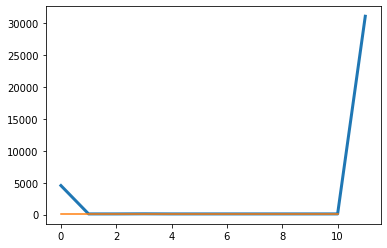

BEST MAPE: 9.387785911560059
with model #1, nb obs: 60, lr: 0.001


In [31]:
model_run(country_name='France', n_seq=200, n_obs=[60,65], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001, 0.01])

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_403 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_404 (LSTM)             (None, 10)                1240      
                                                                 
 dense_312 (Dense)           (None, 10)                110       
                                                                 
 dense_313 (Dense)           (None, 10)                110       
                                       

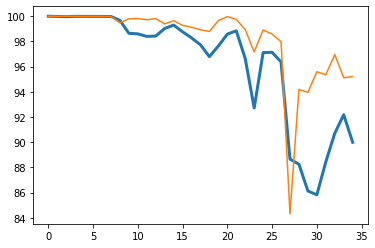

BEST MAPE: 85.81957244873047
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 65, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 65, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 65, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_405 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_406 (LSTM)             (None, 10)                1240      
                                                                 
 dense_314 (Dense)           (None, 10)                110       
                                                                 
 dense_315 (Dense)           (None, 10)

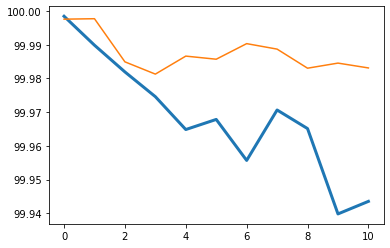

BEST MAPE: 85.81957244873047
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_158"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_407 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_408 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_409 (LSTM)             (None, 10)                1240      
                                                                 
 dense_316 (Dense)           (None, 10)

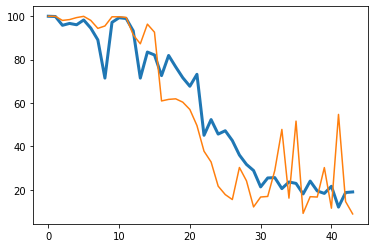

BEST MAPE: 11.985617637634277
with model #2, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 65, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 65, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 65, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_410 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_411 (LSTM)             (None, 65, 20)            3280      
                                                                 
 lstm_412 (LSTM)             (None, 10)                1240      
                                                                 
 dense_318 (Dense)           (None, 10

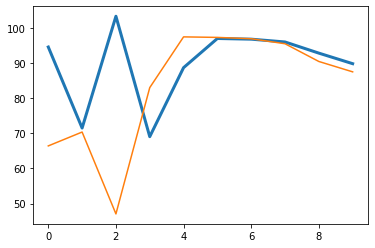

BEST MAPE: 11.985617637634277
with model #2, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_413 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_414 (LSTM)             (None, 60, 30)            6120      
                                                                 
 lstm_415 (LSTM)             (None, 20)                4080      
                                                                 
 dense_320 (Dense)           (None, 10

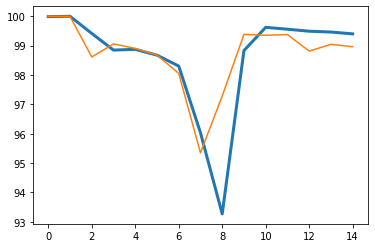

BEST MAPE: 11.985617637634277
with model #2, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 65 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 65, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 65, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 65, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_416 (LSTM)             (None, 65, 20)            3360      
                                                                 
 lstm_417 (LSTM)             (None, 65, 30)            6120      
                                                                 
 lstm_418 (LSTM)             (None, 20)                4080      
                                                                 
 dense_322 (Dense)           (None, 10

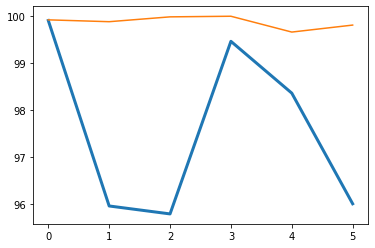

BEST MAPE: 11.985617637634277
with model #2, nb obs: 60, lr: 0.001


In [32]:
model_run(country_name='France', n_seq=200, n_obs=[60, 65], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_419 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_420 (LSTM)             (None, 10)                1240      
                                                                 
 dense_324 (Dense)           (None, 10)                110       
                                                                 
 dense_325 (Dense)           (None, 10)                110       
                                       

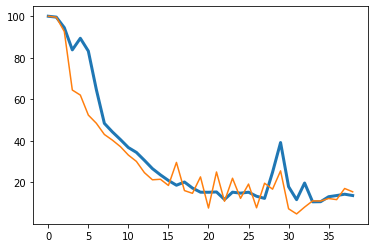

BEST MAPE: 10.603221893310547
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_421 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_422 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_423 (LSTM)             (None, 10)                1240      
                                                                 
 dense_326 (Dense)           (None, 10

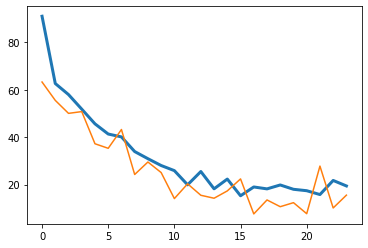

BEST MAPE: 10.603221893310547
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_424 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_425 (LSTM)             (None, 60, 30)            6120      
                                                                 
 lstm_426 (LSTM)             (None, 20)                4080      
                                                                 
 dense_328 (Dense)           (None, 10

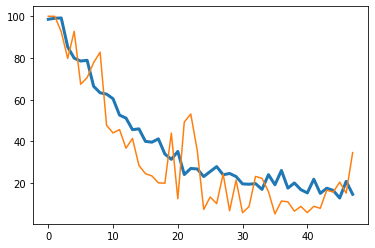

BEST MAPE: 10.603221893310547
with model #1, nb obs: 60, lr: 0.001


In [33]:
model_run(country_name='France', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_448 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_449 (LSTM)             (None, 10)                1240      
                                                                 
 dense_346 (Dense)           (None, 10)                110       
                                                                 
 dense_347 (Dense)           (None, 10)                110       
                                       

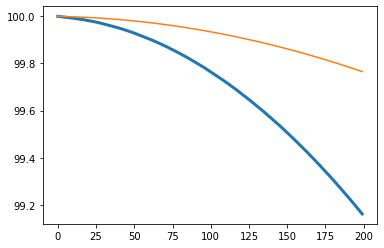

BEST MAPE: 99.16154479980469
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_450 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_451 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_452 (LSTM)             (None, 10)                1240      
                                                                 
 dense_348 (Dense)           (None, 10)

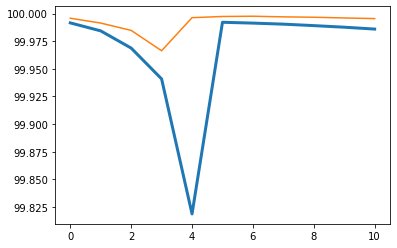

BEST MAPE: 99.16154479980469
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_453 (LSTM)             (None, 60, 30)            6240      
                                                                 
 lstm_454 (LSTM)             (None, 60, 20)            4080      
                                                                 
 lstm_455 (LSTM)             (None, 10)                1240      
                                                                 
 dense_350 (Dense)           (None, 10)

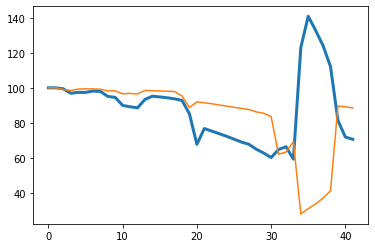

BEST MAPE: 59.31468200683594
with model #3, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_176"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_456 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_22 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_457 (LSTM)             (None, 10)                1240      
                                                                 
 dense_352 (Dense)           (None, 10)

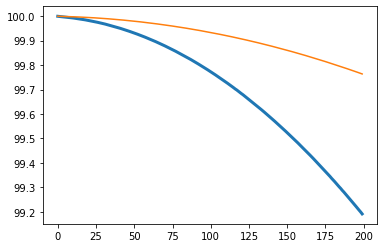

BEST MAPE: 59.31468200683594
with model #3, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_458 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_23 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_459 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_460 (LSTM)             (None, 10)

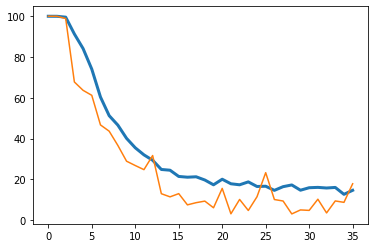

BEST MAPE: 12.692143440246582
with model #5, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_178"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_461 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_24 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_462 (LSTM)             (None, 60, 30)            6120      
                                                                 
 lstm_463 (LSTM)             (None, 20

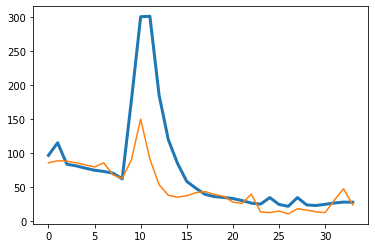

BEST MAPE: 12.692143440246582
with model #5, nb obs: 60, lr: 0.001


In [36]:
model_run(country_name='France', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_448 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_449 (LSTM)             (None, 10)                1240      
                                                                 
 dense_346 (Dense)           (None, 10)                110       
                                                                 
 dense_347 (Dense)           (None, 10)                110       
                                       

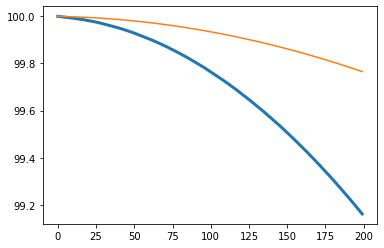

BEST MAPE: 99.16154479980469
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_450 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_451 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_452 (LSTM)             (None, 10)                1240      
                                                                 
 dense_348 (Dense)           (None, 10)

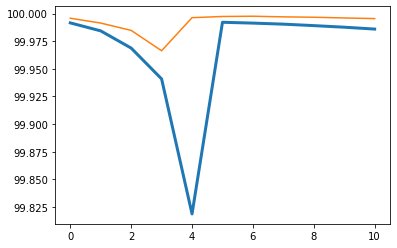

BEST MAPE: 99.16154479980469
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_453 (LSTM)             (None, 60, 30)            6240      
                                                                 
 lstm_454 (LSTM)             (None, 60, 20)            4080      
                                                                 
 lstm_455 (LSTM)             (None, 10)                1240      
                                                                 
 dense_350 (Dense)           (None, 10)

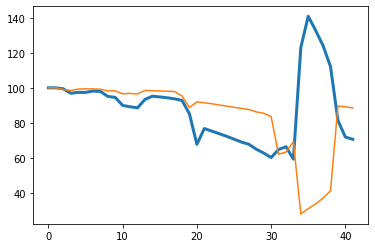

BEST MAPE: 59.31468200683594
with model #3, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_176"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_456 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_22 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_457 (LSTM)             (None, 10)                1240      
                                                                 
 dense_352 (Dense)           (None, 10)

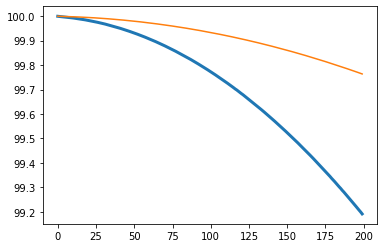

BEST MAPE: 59.31468200683594
with model #3, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_458 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_23 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_459 (LSTM)             (None, 60, 20)            3280      
                                                                 
 lstm_460 (LSTM)             (None, 10)

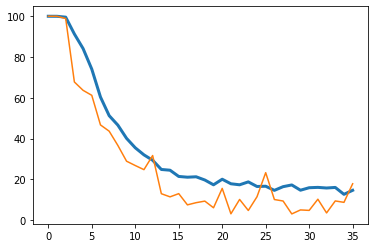

BEST MAPE: 12.692143440246582
with model #5, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_178"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_461 (LSTM)             (None, 60, 20)            3360      
                                                                 
 dropout_24 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_462 (LSTM)             (None, 60, 30)            6120      
                                                                 
 lstm_463 (LSTM)             (None, 20

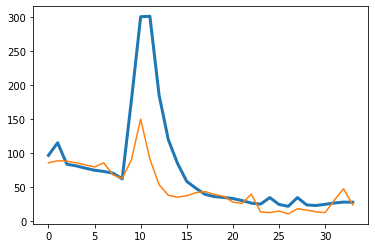

BEST MAPE: 12.692143440246582
with model #5, nb obs: 60, lr: 0.001


In [36]:
model_run(country_name='France', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_209"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_544 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_545 (LSTM)             (None, 10)                1240      
                                                                 
 dense_418 (Dense)           (None, 10)                110       
                                                                 
 dense_419 (Dense)           (None, 10)                110       
                                       

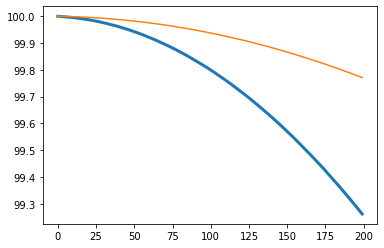

BEST MAPE: 99.26185607910156
with model #1, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_210"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_546 (LSTM)             (None, 60, 30)            6240      
                                                                 
 lstm_547 (LSTM)             (None, 60, 20)            4080      
                                                                 
 lstm_548 (LSTM)             (None, 10)                1240      
                                                                 
 dense_420 (Dense)           (None, 10)

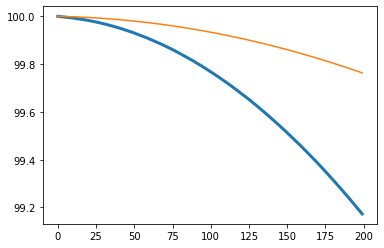

BEST MAPE: 99.17316436767578
with model #2, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_211"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_549 (LSTM)             (None, 60, 30)            6240      
                                                                 
 lstm_550 (LSTM)             (None, 60, 20)            4080      
                                                                 
 lstm_551 (LSTM)             (None, 10)                1240      
                                                                 
 dense_422 (Dense)           (None, 10)

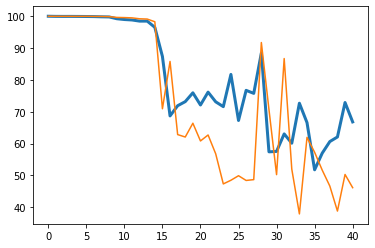

BEST MAPE: 51.753173828125
with model #3, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_212"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_552 (LSTM)             (None, 60, 20)            3360      
                                                                 
 lstm_553 (LSTM)             (None, 10)                1240      
                                                                 
 dense_424 (Dense)           (None, 10)                110       
                                                                 
 dropout_36 (Dropout)        (None, 10)  

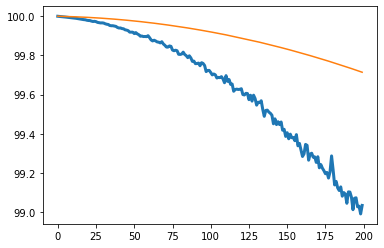

BEST MAPE: 51.753173828125
with model #3, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_213"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_554 (LSTM)             (None, 60, 40)            9920      
                                                                 
 lstm_555 (LSTM)             (None, 60, 30)            8520      
                                                                 
 lstm_556 (LSTM)             (None, 20)                4080      
                                                                 
 dense_426 (Dense)           (None, 10)  

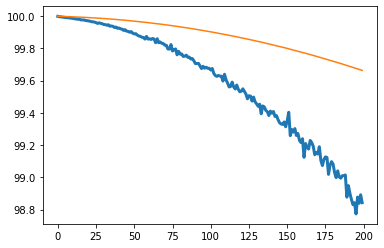

BEST MAPE: 51.753173828125
with model #3, nb obs: 60, lr: 0.001
n_seq		 200 
n_seq_val	 40 
n_seq_test	 20 
n_obs		 60 
n_feat		 20 
n_pred		 10
X_train	 (672, 21) 	->	y_train	 (672,) 
X_val	 (192, 21) 	->	y_val	 (192,) 
X_test	 (97, 21) 	->	y_test	 (97,)
X_train_seq (200, 60, 21) 	->	y_train_seq	 (200, 10) 
X_val_seq (40, 60, 21) 	->	y_val_seq	 (40, 10) 
X_test_seq (20, 60, 21) 	->	y_test_seq	 (20, 10)
Model: "sequential_214"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_557 (LSTM)             (None, 60, 40)            9920      
                                                                 
 lstm_558 (LSTM)             (None, 60, 40)            12960     
                                                                 
 lstm_559 (LSTM)             (None, 30)                8520      
                                                                 
 dense_428 (Dense)           (None, 10)  

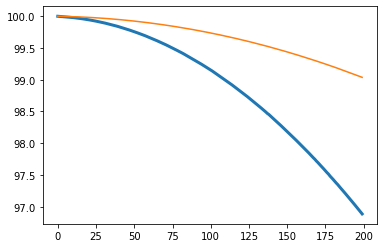

BEST MAPE: 51.753173828125
with model #3, nb obs: 60, lr: 0.001


In [42]:
model_run(country_name='France', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

In [ ]:
model_run(country_name='France', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

In [ ]:
model_run(country_name='United Kingdom', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

In [ ]:
model_run(country_name='Germany', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

In [ ]:
model_run(country_name='United States', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

In [ ]:
model_run(country_name='India', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

In [ ]:
model_run(country_name='Brazil', n_seq=200, n_obs=[60], n_feat=20, n_pred=10, split_train=0.7, split_val=0.9, learning_rates=[0.001])

## **RNN** models on **FRA** country with **Sumedha**'s datasets

In [ ]:
# Sumedha train set
n_seq = 200 ## nb of sequences (samples)
n_obs = [70, 65, 60] # maxi = 96 (stay around 70 or more test_split)
n_obs = 70 # maxi = 96 (stay around 70 or more test_split)
n_feat = 20 #  X_train.shape[1] # 20 feature:
n_pred = 10 # nb of days where we can predict new daily deaths
n_pred = 1 ## <<< REMOVE AFTER OK TESTING!
n_seq_val = n_seq // 5 # number of sequences in test set ?
n_seq_test = n_seq // 10 # number of sequences in test set ?
print('n_seq\t\t', n_seq, '\nn_seq_val\t', n_seq_val, '\nn_seq_test\t', n_seq_test, '\nn_obs\t\t', n_obs, '\nn_feat\t\t', n_feat)

split_train=0.7 ; split_val=0.9

# 0. The Normalization Layer
scaler = MinMaxScaler()
scaler.fit_transform(X_ts_fra_indicator)

train = int((len(X_ts_fra_indicator)*split_train))
val = int(len(X_ts_fra_indicator)*split_val)

X_train = X_ts_fra_indicator[:train]
y_train = y_ts_fra_indicator[:train]

X_val = X_ts_fra_indicator[train:val]
y_val = y_ts_fra_indicator[train:val]

X_test = X_ts_fra_indicator[val:]
y_test = y_ts_fra_indicator[val:]


In [ ]:
model_run(country_name='France', n_seq=200, n_obs=[62, 61, 60], n_feat=20, n_pred=1, split_train=0.7, split_val=0.9, learning_rates=[0.1, 0.01, 0.001])

In [ ]:
model_run(country_name='France', n_seq=200, n_obs=[62, 61, 60], n_feat=20, n_pred=1, split_train=0.7, split_val=0.9, learning_rates=[0.1, 0.05, 0.01])

### RNN model #3 architecture 

In [ ]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_3 = Sequential()
rnn_model_3.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_3.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_3.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_3.add(Dense(n_pred, activation = 'linear'))

### Model #1 evaluating

In [ ]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

### Time Series Forecasting with model #1

### Compile model #3 with 'rmsprop'

In [ ]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_3.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_3.summary()

In [ ]:
rnn_model.summary()

### Train model #2

In [ ]:
history = train_rnn_model(rnn_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, patience=5, epochs=200)
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.show();
type(history)

In [ ]:
trai### Train model #1n_series = [50, 150, 200, 300, 400]
overfit_es =   [2, 6, 6, 5, 6 ]
print('type(overfit_es), overfit_es', type(overfit_es), overfit_es)
# if overfit_es:
#     print("early stopping")
#     history = train_rnn_model(patience=overfit_es)
# else:
# print("No early stopping")
for i in range(len(train_series)):
    history = train_rnn_model(model=rnn_model_2, epochs=train_series[i], patience=overfit_es[i])
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.show();

### RNN model #3 architecture 

#### 🚀 The **LSTM (= Long Short Term Memory)** with their ability to *avoid the vanishing gradient problem*, should be preferred over a SimpleRNN.

In [ ]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_3 = Sequential()
rnn_model_3.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_3.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_3.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_3.add(Dense(n_pred, activation = 'linear'))

### Compile model #3 with 'rmsprop'

In [ ]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_3.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_3.summary()

### Train model #2

### RNN model #3 architecture 

In [ ]:
# 1. The Architecture
"""   - 3rd model layers architecture (simple -> complex) (less data -> more data) (print(loss) function check lecture)
> LSTM
"""
rnn_model_3 = Sequential()
rnn_model_3.add(normalizer) # Using the Normalization layer to standardize the datapoints during the forward pass
# Input len(train) (input_shape=(?,?))
rnn_model_3.add(LSTM(units=30, activation='tanh'))  ## , input_shape=(?,?))) without a Normalizer layer
# output return sequences = True
rnn_model_3.add(Dense(10, activation = 'relu')) ## add 1 or more 'relu' layers
# Output 10 only, no more RNN just dropout()
# rnn_model_3.add(layers.Dropout(0.3)) ## if RNN model over-fit
rnn_model_3.add(Dense(n_pred, activation = 'linear'))

### Compile model #3 with 'rmsprop'

In [ ]:
# 2. Compiling with 'rmsprop' rather than 'adam' (recommended)
optimizer = RMSprop(
                learning_rate=0.001,
                rho=0.9,
                momentum=0.0,
                epsilon=1e-07,
                centered=False
            )
rnn_model_3.compile(loss='mse',
              optimizer= optimizer, # optimizer='rmsprop'    <- adapt learning rate
                 metrics='mape')  # Recommended optimizer for RNNs
rnn_model_3.summary()

### Train model #3

### Train model #2

In [ ]:
# min(history.history['mape'])

# print("adjust early stopping")
# overfit_es = [d[0]+1 for d in enumerate(history.history['mape']) if d[1] == min(history.history['mape'])][0]
# overfit_es

In [ ]:
min(history.history['mape']), max(history.history['mape']), history.history['mape'] # blue line

In [ ]:
max(history.history['val_mape']), history.history['val_mape'] # orange line

### Model #1 evaluating

In [ ]:
# 4. Evaluating
# The prediction (one per sequence/city)
y_pred = rnn_model.predict(X_test) 
print(y_pred.shape)
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

### Time Series Forecasting with model #1

In [ ]:
# Check your code below
assert y_pred.shape == (n_seq_test, n_pred)
# Distribution of the real values y_train
pd.DataFrame(y_train).mean().sort_values(ascending=False)

In [ ]:
# Distribution of the real values y_train
pd.DataFrame(y_train).mean().sort_values(ascending=False)

In [ ]:
trai### Train model #1n_series = [50, 150, 200, 300, 400]
overfit_es =   [2, 6, 6, 5, 6 ]
print('type(overfit_es), overfit_es', type(overfit_es), overfit_es)
# if overfit_es:
#     print("early stopping")
#     history = train_rnn_model(patience=overfit_es)
# else:
# print("No early stopping")
for i in range(len(train_series)):
    history = train_rnn_model(model=rnn_model_2, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=train_series[i], patience=overfit_es[i])
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.show();

In [ ]:
data_index=data_index.set_index('date')